### Data Augmentation using torch.vision and Albumentations

**Date:** 13/11/2021  
**Author:** Murad Popattia

### Torch.Vision

In [4]:
# import libraries
import torch
import torch.nn as nn # all the layers
import torch.optim as optim # all the optimization algos
import torch.nn.functional as F # all the activation functions
from torch.utils.data import DataLoader, Dataset # helps to create mini-batches etc.
import torchvision # for importing models
import torchvision.transforms as transforms # for transformations on the dataset
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import spacy
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import matplotlib.patches as patches

device = "cuda" if torch.cuda.is_available() else "cpu"

Reutilizing the cats and dogs dataset made

In [9]:
# define the transformations
my_transforms = transforms.Compose([
    transforms.ToPILImage(), # all the transforms work on this
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomHorizontalFlip(p=0.5), # we define a probability for the flip as well
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0])
])

"""
Normalize helps in training, but for this case it is not doing anything as subtract zero and divide by 1.
We would find those values first across all channels and then mention them here, to help in training
"""

'\nNormalize helps in training, but for this case it is not doing anything as subtract zero and divide by 1.\nWe would find those values first across all channels and then mention them here, to help in training\n'

We can visualize the augmentations as well

In [6]:
# read in the two images
img_1 = cv2.imread("../datasets/augmentation_dataset_cats/cat.1.jpg")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

img_2 = cv2.imread("../datasets/augmentation_dataset_cats/cat.2.jpg")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

In [7]:
img_path = "../datasets/augmentation_dataset_cats/"

imgs = []

img_count = 3
for img in [img_1, img_2]:
    for _ in range(10):
        temp = my_transforms(img)
        utils.save_image(temp, f"{img_path}cat.{img_count}.png")
        imgs.append(temp)
        
        img_count += 1

In [5]:
len(imgs)

10

### Visualizing the augmentations

torch.Size([3, 906, 1132])


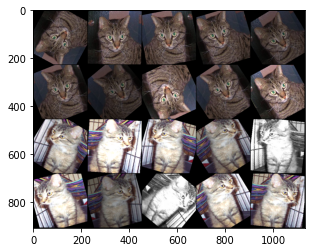

In [8]:
# helper function of displaying the dataset
def show(img):
    npimg = img.numpy() # convert the tensor to numpy

    # convert to h*w*c from c*h*w
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    
x_grid = utils.make_grid(imgs, nrow = 5) # nrow means the no. of images per column
print(x_grid.shape)
show(x_grid)

### Albumentations

#### Benefits:
- Faster than torch.vision on almost all benchmarks
- Has support for classification and segmentation tasks which are hard to do with torch.vision

In [3]:
import albumentations as A

**Some util functions**

In [19]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    plt.show()


def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = 5

    for i in range(1, len(images)):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name="Elon")
        else:
            img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()


# From https://albumentations.ai/docs/examples/example_bboxes/
def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img

### Case 1: Classification Problems

In [20]:
img = Image.open("../datasets/augmentation_data_albumentations/img_1.jpg")

In [21]:
# applying the transformations
# we can build these complicated trees of augmentation
my_transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT), # done to avoid reflection after rotation
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        
        # one of these would be chosen 
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5)
        ], p=0.1)
    ]
)

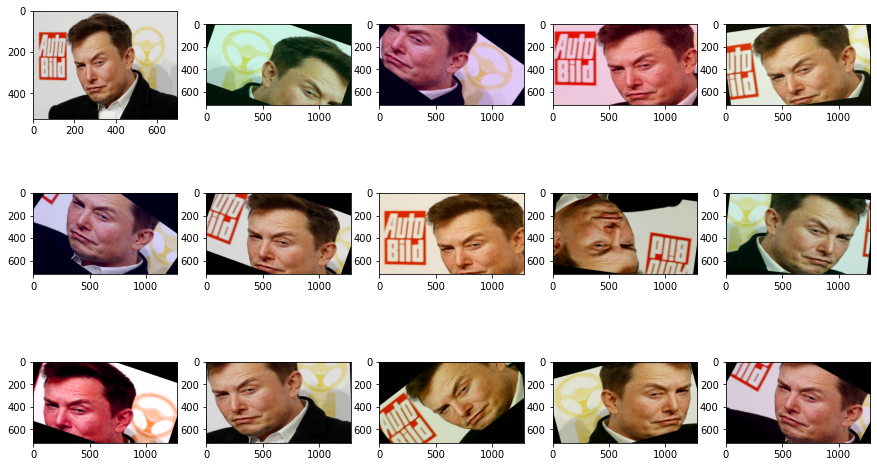

In [22]:
img_list = [img]
img = np.array(img)

for i in range(15):
    augmentations = my_transform(image=img)
    
    # augmentations returns a dictionary
    augmented_img = augmentations["image"]
    img_list.append(augmented_img)
    
plot_examples(img_list)

### Case 2: Segmentation Problems

In [23]:
mask = Image.open("../datasets/augmentation_data_albumentations/mask_1.jpg")

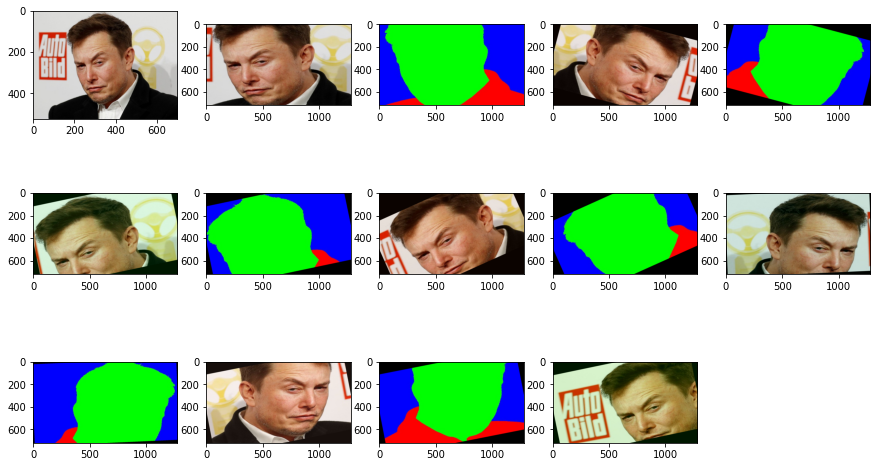

In [27]:
img_list = [img]
img = np.array(img)
mask = np.array(mask)

for i in range(7):
    augmentations = my_transform(image=img, mask=mask) # the only change here
    # augmentations = my_transform(image=img, mask=[mask, mask2])
    
    # augmentations returns a dictionary
    augmented_img = augmentations["image"]
    augmented_mask = augmentations["mask"] # obtaining the mask
    img_list.append(augmented_img)
    img_list.append(augmented_mask)
    
    # we can then obtain items from the mask list as:
    # img_list.append(augmented_mask[0])
    # img_list.append(augmented_mask[1]) .. etc.
    
plot_examples(img_list)

### Case 3: Detection Problems

In [132]:
img = cv2.imread("../datasets/augmentation_data_albumentations/cat.png") # read using cv2 so no need to convert to numpy array
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

'''
We need to know the format of the bounding box as well
Pascal_voc (x_min, y_min, x_max, y_max), different for YOLO, COCO etc.
'''

# we need to send in the bounding box coords as well such as
bboxes = [[13,170,285,510]] # where each element of the list corresponds to the bounding boxes in the image

In [133]:
my_transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT), # done to avoid reflection after rotation
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        
        # one of these would be chosen 
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5)
        ], p=0.1)
    ], bbox_params = A.BboxParams(format = "pascal_voc", min_area=2048, min_visibility=0.3, label_fields = []) # label_fields is to specify the class labels for each bbox
)

# min_area means that the bbox should cover 2048px from the entire image
# min_visbility

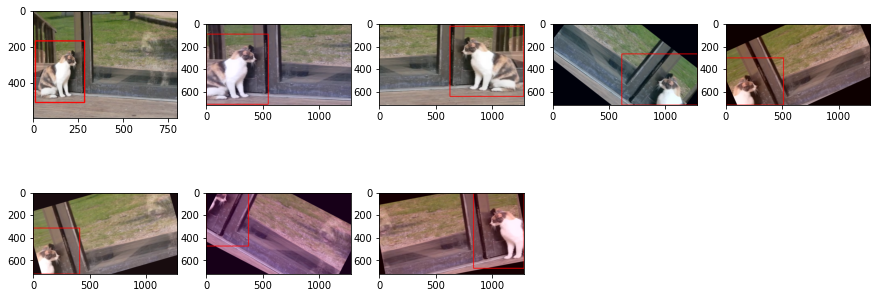

In [135]:
img_list = [img]
img = np.array(img)
saved_bboxes = [bboxes[0]]

for i in range(10):
    augmentations = my_transform(image=img, bboxes=bboxes) # the only change here
    # augmentations = my_transform(image=img, mask=[mask, mask2])
    
    # augmentations returns a dictionary
    augmented_img = augmentations["image"]
    
    if len(augmentations["bboxes"]) == 0: # meaning that the bounding box was dropped
        continue
    
    img_list.append(augmented_img)        
    saved_bboxes.append(augmentations["bboxes"][0])
    
plot_examples(img_list, saved_bboxes)

### An example with the Dataset

In [139]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files))) # this will put 0 as label for all cats and 1 for all dogs
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))
        
        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]
            
        return image, label

In [141]:
from albumentations.pytorch import ToTensorV2

my_transform = A.Compose(
    [
        A.Resize(width=1920, height=1080),
        A.RandomCrop(width=1280, height=720),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT), # done to avoid reflection after rotation
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        
        # one of these would be chosen 
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5)
        ], p=0.1),
        # necessary to do this as unlike ToTensor() which does Normalize(mean, stds), Albumentations does not do that, so necessary to call this
        A.Normalize(
            mean = [0,0,0],
            std = [1,1,1],
            max_pixel_value=255, 
        ),
        ToTensorV2(), # this does not divide by 255 at the end
    ]
)

In [144]:
dataset = ImageDataset(root_dir="../datasets/sample_cats_and_dogs", transform = my_transform)

In [146]:
for x,y in dataset:
    print(x.shape, y)

torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 0
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
torch.Size([3, 720, 1280]) 1
